In [61]:
import os
import gudhi
import math
import dcor
import numpy as np
import pandas as pd
from gudhi import RipsComplex
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from gudhi.representations import Landscape, PersistenceImage
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [62]:
#READ GENE EXPRESSION MATRICES AS PICKLE FILES

In [63]:
def read_files_create_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    df.columns = [ref] * df.shape[1]
    
    df = df.T
    df = df.drop(columns=np.nan)
    
    df_quant = quantile_transform(df, n_quantiles=df.shape[0])
    df_quant = pd.DataFrame(df_quant)
    df_quant.columns = df.columns
    df_quant.index = df.index
    
    return(df)

In [64]:
GSE19860_R = read_files_create_dataframe('GSE19860_RESISTANT_FOLFOX.csv', 'r')
GSE19860_S = read_files_create_dataframe('GSE19860_SENSITIVE_FOLFOX.csv', 's')

GSE28702_R = read_files_create_dataframe('GSE28702_RESISTANT_FOLFOX.csv', 'r')
GSE28702_S = read_files_create_dataframe('GSE28702_SENSITIVE_FOLFOX.csv', 's')

GSE52735_R = read_files_create_dataframe('GSE52735_RESISTANT_FOLFOX.csv', 'r')
GSE52735_S = read_files_create_dataframe('GSE52735_SENSITIVE_FOLFOX.csv', 's')

GSE69657_R = read_files_create_dataframe('GSE69657_RESISTANT_FOLFOX.csv', 'r')
GSE69657_S = read_files_create_dataframe('GSE69657_SENSITIVE_FOLFOX.csv', 's')

GSE72968_R = read_files_create_dataframe('GSE72968_RESISTANT_FOLFOX.csv', 'r')
GSE72968_S = read_files_create_dataframe('GSE72968_SENSITIVE_FOLFOX.csv', 's')

In [65]:
array_r = pd.concat([GSE19860_R, GSE28702_R, GSE52735_R, GSE69657_R, GSE72968_R], axis=0)
array_s = pd.concat([GSE19860_S, GSE28702_S, GSE52735_S, GSE69657_S, GSE72968_S], axis=0)
#array = quantile_transform(array, n_quantiles=10, random_state=0, copy=True)

In [66]:
GSE81653_R = read_files_create_dataframe('GSE81653_FOLFOX_RESISTANT.csv', 'r')
GSE81653_S = read_files_create_dataframe('GSE81653_FOLFOX_SENSITIVE.csv', 's')

In [67]:
def read_files_rna_dataframe(path, ref):
    
    labelencoding = preprocessing.LabelEncoder()
    
    file_directory = '/Users/lebohangmashatola/Downloads/CRCPhenotypePredictionTool-main/expression/' + path
    df = pd.read_csv(file_directory, sep=',', index_col=0)
    
    df.index = [ref] * df.shape[0]
    
    return(df)

In [68]:
rna_r = read_files_rna_dataframe('rnaseq_folfox_r.csv', 'r')
rna_s = read_files_rna_dataframe('rnaseq_folfox_s.csv', 's')

In [69]:
def train_test(case, control):
    
    labelencoding = preprocessing.LabelEncoder()
    df = pd.concat([case, control], axis=0)
    
    biomarker_genes = '/Users/lebohangmashatola/downloads/CRCPhenotypePredictionTool-main/biomarkers/choline.csv'
    biomarkers = pd.read_csv(biomarker_genes, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()  
    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)] #Subset biomarker genes
    
    train, test = train_test_split(gene_exprs_matrix, test_size=0.3, train_size=0.7, random_state=0, shuffle=True)
            
    train_labs = labelencoding.fit_transform(train.index.to_list())
    test_labs = labelencoding.fit_transform(test.index.to_list())
    
    return (np.array(train), np.array(test), train_labs, test_labs)

In [70]:
GSE81653_train, GSE81653_test, GSE81653_train_labs, GSE81653_test_labs = train_test(GSE81653_R, GSE81653_S)

In [71]:
array_train, array_test, array_train_labs, array_test_labs = train_test(array_r, array_s)

In [72]:
rnaseq_train, rnaseq_test, rnaseq_train_labs, rnaseq_test_labs = train_test(rna_r, rna_s)

In [73]:
#Convoluted Neural Network 

In [74]:
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from keras import backend as K

In [75]:
def convoluted(X_train, X_test, y_train, y_test):
    
    from keras import backend as K
    
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision

    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
        
    X_train = np.expand_dims(X_train, axis=2).astype('float32')
    X_test = np.expand_dims(X_test, axis=2).astype('float32')
    
    model = Sequential()

    model.add(Conv1D(filters=1024, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
    #keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
    
    history = model.fit(X_train, y_train, epochs = 30, shuffle=True, verbose=0)
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    
    scores = np.array([f1_score*100, recall*100, precision*100, accuracy*100])
    
    return scores
    

In [76]:
gse = convoluted(GSE81653_train, GSE81653_test, GSE81653_train_labs, GSE81653_test_labs)

In [77]:
arr = convoluted(array_train, array_test, array_train_labs, array_test_labs)

In [78]:
rna = convoluted(rnaseq_train, rnaseq_test, rnaseq_train_labs, rnaseq_test_labs)

In [79]:
all_metrics = np.stack([gse, arr, rna])

<AxesSubplot:>

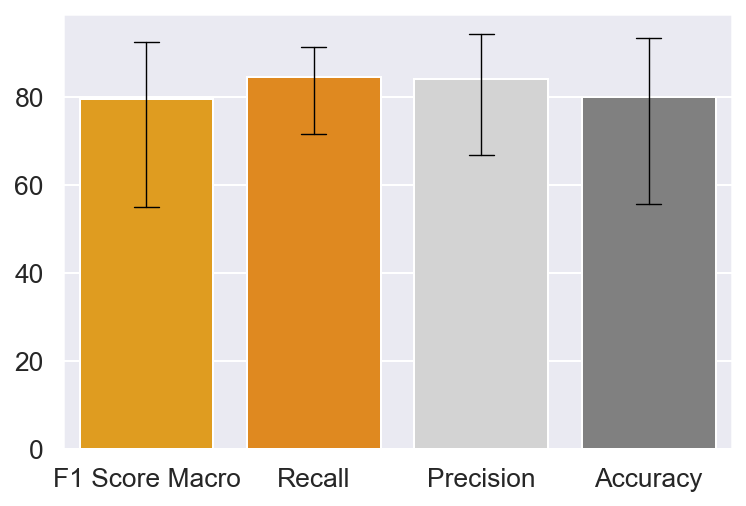

In [101]:
c = pd.DataFrame(all_metrics,
             index=['GSE81653', 'Array', 'RNASeq'], 
             columns=['F1 Score Macro', 'Recall', 'Precision', 'Accuracy'])

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(font_scale=1.2)
color = ['orange','darkorange','lightgrey', 'grey']
sns.barplot(data=c, capsize=0.15, errcolor="0", errwidth=0.7, palette=color)

In [81]:
def MLPClass(X_train, X_test, y_train, y_test):
    
    from sklearn.neural_network import MLPClassifier
    
    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average="macro")
    pr = precision_score(y_test, y_pred, average="macro")
    re = recall_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    
    scores = np.array([f1*100, re*100, pr*100, acc*100])
    return scores

In [82]:
gse = MLPClass(GSE81653_train, GSE81653_test, GSE81653_train_labs, GSE81653_test_labs)

In [83]:
arr = MLPClass(array_train, array_test, array_train_labs, array_test_labs)

In [84]:
rna = MLPClass(rnaseq_train, rnaseq_test, rnaseq_train_labs, rnaseq_test_labs)

In [85]:
all_metrics = np.stack([gse, arr, rna])

<AxesSubplot:>

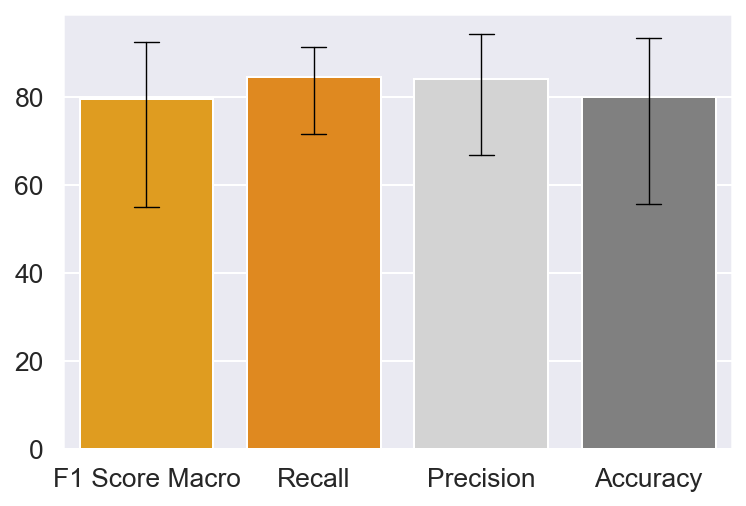

In [99]:
c = pd.DataFrame(all_metrics,
             index=['GSE81653', 'Array', 'RNASeq'], 
             columns=['F1 Score Macro', 'Recall', 'Precision', 'Accuracy'])

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(font_scale=1.2)
color = ['orange','darkorange','lightgrey', 'grey']
sns.barplot(data=c, capsize=0.15, errcolor="0", errwidth=0.7, palette=color)

In [87]:
def RFClass(X_train, X_test, y_train, y_test):
    
    from sklearn.ensemble import RandomForestClassifier
    
    clf = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average="macro")
    pr = precision_score(y_test, y_pred, average="macro")
    re = recall_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    
    scores = np.array([f1*100, re*100, pr*100, acc*100])
    return scores

In [88]:
gse = RFClass(GSE81653_train, GSE81653_test, GSE81653_train_labs, GSE81653_test_labs)

In [89]:
arr = RFClass(array_train, array_test, array_train_labs, array_test_labs)

In [90]:
rna = RFClass(rnaseq_train, rnaseq_test, rnaseq_train_labs, rnaseq_test_labs)

In [91]:
all_metrics = np.stack([gse, arr, rna])

<AxesSubplot:>

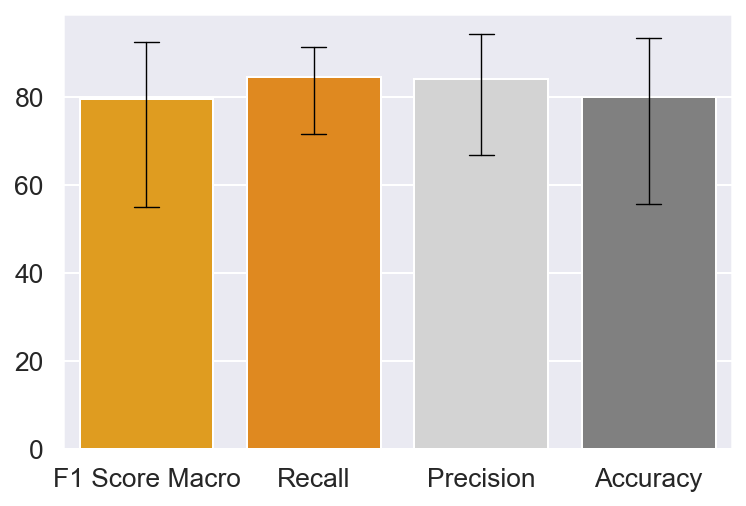

In [100]:
c = pd.DataFrame(all_metrics,
             index=['GSE81653', 'Array', 'RNASeq'], 
             columns=['F1 Score Macro', 'Recall', 'Precision', 'Accuracy'])

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(font_scale=1.2)
color = ['orange','darkorange','lightgrey', 'grey']
sns.barplot(data=c, capsize=0.15, errcolor="0", errwidth=0.7, palette=color)